In [10]:
from mnist import MNIST
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np 
import cv2 
from collections import deque 
import time
import os
from keras.models import load_model

def create_model():
    model = Sequential()
    model.add(Input(shape = (28, 28))) # input layer
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512, activation='relu')) # hidden layer
    model.add(Dropout(0.2)) # prevent overfitting
    model.add(Dense(512, activation='relu')) # hidden layer
    model.add(Dropout(0.2)) # prevent overfitting
    model.add(Dense(26, activation='softmax')) # output layer
    return model

def train_model():
    print('--------- Training New Model -----------')
    data = MNIST(path='data/', return_type='numpy')
    data.select_emnist('letters')
    X, y = data.load_training()
    
    X = X.reshape(124800, 28, 28)
    y = y.reshape(124800, 1)
    
    y = y - 1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    
    y_train = to_categorical(y_train, num_classes = 26)
    y_test = to_categorical(y_test, num_classes = 26)

    checkpoint_weights_path = 'best_model.keras'

    model = create_model()
    model.summary()
    model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath = checkpoint_weights_path, verbose = 1, save_best_only = True)
    
    model.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_split = 0.2, callbacks = [checkpointer], verbose = 1, 
              shuffle = True)
    print('Model saved successfully : best_model.keras')


training = input("Do you want to train a new model? Press (Y) for Yes else (N) for No")

if training == 'Y':
    train_model()

model = load_model('model_hand.h5')

def color_detector():
    def setValues(x):
        print("")
    # creating a window for HUE selector
    cv2.namedWindow("Color detectors") 
    cv2.createTrackbar("Upper Hue", "Color detectors", 153, 180, setValues) 
    cv2.createTrackbar("Upper Saturation", "Color detectors", 255, 255, setValues) 
    cv2.createTrackbar("Upper Value", "Color detectors", 255, 255, setValues) 
    cv2.createTrackbar("Lower Hue", "Color detectors", 64, 180, setValues) 
    cv2.createTrackbar("Lower Saturation", "Color detectors", 72, 255, setValues) 
    cv2.createTrackbar("Lower Value", "Color detectors", 49, 255, setValues)

def prediction_from_image(image_save_path):
    # Dictionary for getting characters from index values...
    word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}
    
    img = cv2.imread(image_save_path)
    img_copy = img.copy()
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (400,440))
    
    img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    _, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)
    
    img_final = cv2.resize(img_thresh, (28,28))
    img_final =np.reshape(img_final, (1,28,28,1))
    img_pred = word_dict[np.argmax(model.predict(img_final))]
    return img_pred
    
image_save_path = os.path.join(os.getcwd(), "last_frame.jpg")
color_detector()

bpoints = [deque(maxlen = 512)] 
gpoints = [deque(maxlen = 512)] 
ypoints = [deque(maxlen = 512)] 
rpoints = [deque(maxlen = 512)] 

# Now to mark the pointers in the above colour array we introduce some index values Which would mark their positions  

blue_index = 0
green_index = 0
yellow_index = 0
red_index = 0

# The kernel is used for dilation of contour

kernel = np.ones((5, 5)) 

# The ink colours for the drawing purpose 
 
colors = [(255, 0, 0), (0, 255, 0), (0, 225, 255), (0, 0, 255)] 
colorIndex = 0

# Setting up the drawing board AKA The canvas 

paintWindow = np.zeros((1500, 1500, 3)) + 255

cv2.namedWindow('Paint', cv2.WINDOW_AUTOSIZE) 
 
cap = cv2.VideoCapture(0) 
prediction = 'NA'
while True: 

    # Reading the camera frame 
    ret, frame = cap.read() 
    # For saving
    # out = cv2.VideoWriter("Paint-Window.mp4", cv2.VideoWriter_fourcc(*'XVID'), 1, (frame.shape[1], frame.shape[0]))
    
    # Flipping the frame to see same side of the user  
    frame = cv2.flip(frame, 1) 
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 

    # Getting the new positions of the trackbar and setting the new HSV values 

    u_hue = cv2.getTrackbarPos("Upper Hue", "Color detectors") 
    u_saturation = cv2.getTrackbarPos("Upper Saturation", "Color detectors") 
    u_value = cv2.getTrackbarPos("Upper Value","Color detectors") 
    l_hue = cv2.getTrackbarPos("Lower Hue", "Color detectors") 
    l_saturation = cv2.getTrackbarPos("Lower Saturation", "Color detectors") 
    l_value = cv2.getTrackbarPos("Lower Value", "Color detectors") 
    Upper_hsv = np.array([u_hue, u_saturation, u_value]) 
    Lower_hsv = np.array([l_hue, l_saturation, l_value]) 

    # Adding the colour buttons to the live frame to choose color
    frame = cv2.rectangle(frame, (35, 1), (135, 65), (122, 122, 122), -1) 
    frame = cv2.rectangle(frame, (160, 1), (255, 65), (255, 0, 0), -1) 
    frame = cv2.rectangle(frame, (275, 1), (370, 65), (0, 255, 0), -1) 
    frame = cv2.rectangle(frame, (390, 1), (485, 65), (0, 255, 255), -1) 
    frame = cv2.rectangle(frame, (505, 1), (600, 65), (0, 0, 255), -1) 

    cv2.putText(frame, "Clear All", (55, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Blue Color", (175, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 
    
    cv2.putText(frame, "Green Color", (285, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Yellow Color", (400, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 150, 150), 2, cv2.LINE_AA) 

    cv2.putText(frame, "Red Color", (520, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 2, cv2.LINE_AA) 


    # masking out the pointer for it's identification in the frame 

    Mask = cv2.inRange(hsv, Lower_hsv, Upper_hsv) 
    Mask = cv2.erode(Mask, kernel, iterations = 1) 
    Mask = cv2.morphologyEx(Mask, cv2.MORPH_OPEN, kernel) 
    Mask = cv2.dilate(Mask, kernel, iterations = 1) 

    # Now contouring the pointers post identification 
    lower_red = np.array([100,60,60])
    upper_red = np.array([140,255,255])
    red_mask = cv2.inRange(hsv, lower_red, upper_red)
    red_mask = cv2.erode(red_mask, kernel, iterations=1)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_mask = cv2.dilate(red_mask, kernel, iterations=1)

    countours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centre = None

    # If there are any contours formed 
    if len(countours) > 0: 
        
        # sorting the contours for the biggest 
        countour = sorted(countours, key = cv2.contourArea, reverse = True)[0] 
        # Get the radius of the cirlce formed around the found contour   
        ((x, y), radius) = cv2.minEnclosingCircle(countour) 
        
        # Drawing the circle boundary around the contour 
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2) 
        
        # Calculating the centre of the detected contour 
        M = cv2.moments(countour) 
        centre = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])) 
        
        # Now checking if the user clicked on another button on the screen (the 4 buttons that were mentioned Y,G,B,R and clear all)
        if centre[1] <= 65: 
            
            # Clear Button 
            if 35 <= centre[0] <= 135: 
                bpoints = [deque(maxlen = 512)] 
                gpoints = [deque(maxlen = 512)] 
                ypoints = [deque(maxlen = 512)] 
                rpoints = [deque(maxlen = 512)] 

                blue_index = 0
                green_index = 0
                yellow_index = 0
                red_index = 0

                paintWindow[67:, :, :] = 255
            elif 160 <= centre[0] and centre[0] <= 255: 
                colorIndex = 0 # Blue 
                    
            elif 275 <= centre[0] and centre[0] <= 370: 
                colorIndex = 1 # Green 
            elif 390 <= centre[0] and centre[0] <= 485: 
                colorIndex = 2 # Yellow
            elif 505 <= centre[0] and centre[0] <= 600: 
                colorIndex = 3 # Red 
        else : 
            if colorIndex == 0: 
                bpoints[blue_index].appendleft(centre) 
            elif colorIndex == 1: 
                gpoints[green_index].appendleft(centre) 
            elif colorIndex == 2: 
                ypoints[yellow_index].appendleft(centre) 
            elif colorIndex == 3: 
                rpoints[red_index].appendleft(centre) 
                
    # Appending the next deques if nothing is detected

    else: 
        bpoints.append(deque(maxlen = 512)) 
        blue_index += 1
        gpoints.append(deque(maxlen = 512)) 
        green_index += 1
        ypoints.append(deque(maxlen = 512)) 
        yellow_index += 1
        rpoints.append(deque(maxlen = 512)) 
        red_index += 1

    # Drawing the lines of every colour on the canvas and the track frame window
    
    points = [bpoints, gpoints, ypoints, rpoints] 
    for i in range(len(points)): 
        for j in range(len(points[i])): 
            for k in range(1, len(points[i][j])): 
                if points[i][j][k - 1] is None or points[i][j][k] is None: 
                    continue
                    
                cv2.line(frame, points[i][j][k - 1], points[i][j][k], colors[i], 30) 
                # cv2.line(paintWindow, points[i][j][k - 1], points[i][j][k], colors[i], 30)
                cv2.line(paintWindow, points[i][j][k - 1], points[i][j][k], (0, 0, 0), 30)

    key = cv2.waitKey(1)    

    # letter_predictor = LetterPredictor()        
    if key & 0xFF == ord('v'):          
        cv2.imwrite(image_save_path, paintWindow)
        prediction = prediction_from_image(image_save_path)

    # letter_predictor = LetterPredictor()        
    if key & 0xFF == ord('c'):           
        bpoints = [deque(maxlen = 512)] 
        gpoints = [deque(maxlen = 512)] 
        ypoints = [deque(maxlen = 512)] 
        rpoints = [deque(maxlen = 512)] 
        blue_index = 0
        green_index = 0
        yellow_index = 0
        red_index = 0
        paintWindow[:, :, :] = 255
        
    cv2.putText(frame, "Prediction: " + str(prediction), (20,800), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,102,0), 8)
    cv2.putText(frame, "V to predict", (1500,400), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    cv2.putText(frame, "C to Clear", (1500,500), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    cv2.putText(frame, "Q to Quit", (1500,600), cv2.FONT_HERSHEY_SIMPLEX, 2, (102,51,0), 8)
    
    # Displaying/running all the 3 windows 
    cv2.imshow("Live Tracking", frame) 
    cv2.imshow("Paint", paintWindow) 
    # cv2.imshow("mask", Mask) 
    
    # For quitting/breaking the loop - press and hold ctrl+q twice 
    if key & 0xFF == ord("q"): 
        break

# Releasing the camera and all the other resources of the device  
cap.release() 
cv2.destroyAllWindows() 
cv2.waitKey(1) 

Do you want to train a new model? Press (Y) for Yes else (N) for No N








1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms

-1

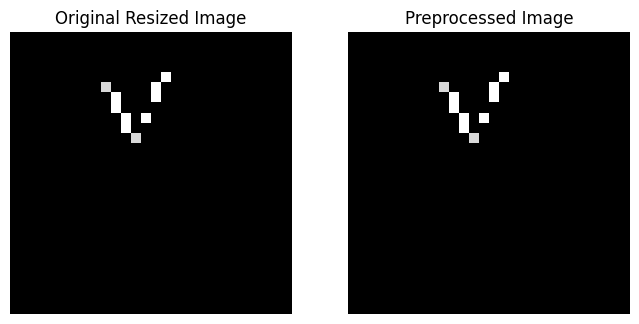

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted Letter: T


In [11]:
# Load your CNN model
import matplotlib.pyplot as plt
model = load_model('model_hand.h5')  # Load your trained model

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_save_path)
    img_copy = img.copy()
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (400,440))
    
    img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    _, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)
    
    img_final = cv2.resize(img_thresh, (28,28))
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_final, cmap='gray')
    plt.title('Original Resized Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_final.reshape(28, 28), cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')
    
    plt.show()
    img_final =np.reshape(img_final, (1,28,28,1))
    return img_final

# Function to predict letter from image
def predict_letter(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction)
    # Assuming your classes are labeled as 0 to 25 for letters A to Z
    predicted_letter = chr(predicted_class + 65)  # Convert class index to corresponding letter
    return predicted_letter

# Example usage
image_path = os.path.join(os.getcwd() ,'last_frame.jpg')  # Path to your image
predicted_letter = predict_letter(image_path)
print("Predicted Letter:", predicted_letter)
